In [125]:
import warnings

import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.errors import ShapelyDeprecationWarning
import rasterio
import rasterio.mask
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from scrollstats import BendDataset, create_transects, calculate_ridge_metrics

In [48]:
raster_paths = {"LBR_025":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_1_025_clip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_1_025_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif"
                }, 
                "LBR_029":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_1_029_clip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_1_029_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif"
                }, 
                "LBR_043":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_1_043_clip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_1_043_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif"
                }, 
                "LBR_077":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_4_077_clip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_4_077_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif"
                },
                "MIS_005":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/strick/raster/dem/m5_merged_clipped.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/strick/raster/agreement/m5_merged_agreement_15px_clip_binclass_dn_Buff0m_SmFt035m_ET80p.tif"
                }}

In [28]:
new_bend_boundaries = gpd.read_file("/Users/avan/Downloads/drive-download-20230426T041016Z-001/LBR_bounds_new.shp").set_index("bend_id").to_crs("EPSG:4326")
new_bend_boundaries

,Shape_Leng,Shape_Area,geometry
bend_id,,,
LBR_025,6039.689897,1.046121e+06,"POLYGON ((-96.50403 30.61769, -96.50372 30.617..."
LBR_029,3903.452794,5.628150e+05,"POLYGON ((-96.38801 30.54180, -96.38800 30.541..."
LBR_043,3612.673218,5.441414e+05,"POLYGON ((-96.28624 30.37048, -96.28615 30.370..."
LBR_077,6106.047986,1.469137e+06,"POLYGON ((-95.87800 29.59661, -95.87795 29.596..."


In [37]:
def update_bend_geom(bend_id):
    # Get old bend info
    bend_ds = BendDataset(bend_id)
    db_engine = bend_ds.db_engine
    old_bend = bend_ds.get_bend()

    # Get new bend info
    new_geom = new_bend_boundaries.loc[bend_id, "geometry"]
    new_bend = old_bend.copy()

    # Update
    new_bend.loc[0, "geometry"] = new_geom
    new_bend.loc[0, "bend_id"] = "new_" + bend_id

    new_bend.to_postgis("bends", db_engine, index=False, if_exists="append")

In [43]:
# for i in new_bend_boundaries.index.values:
#     update_bend_geom(i)



Update the packet boundaries
1. Read in packets from db
2. Read in new packets
3. Make copy of db packets
4. 

## Clip the rasters


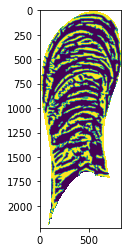

In [67]:
# PROCESSING
bend_id = "LBR_077"

gdf = BendDataset(bend_id).get_bend().to_crs("EPSG:32140")
poly = gdf.geometry
raster_path  = Path(raster_paths[bend_id]["bin"])
out_dir = Path('/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds')


with rasterio.open(raster_path) as src:
    out_img, out_transform = rasterio.mask.mask(src, poly, nodata=np.nan, crop=True)
    out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "nodata": np.nan})

out_name = f"{raster_path.stem}_newclip.tif"
out_path = out_dir / out_name

# Create the out_dir if it does not already exist
if not out_path.parent.exists():
    out_path.parent.mkdir(parents=True)

# Write to disk with rasterio
with rasterio.open(out_path, 'w', **out_meta) as dst:
    dst.write(out_img)

# Sanity plot
ds = rasterio.open(out_path)
arr = ds.read(1)
plt.imshow(arr)

## Create new transects

In [156]:
bend_id = "LBR_077"

bend_ds = BendDataset(bend_id)
cl = bend_ds.get_centerline(proj=True)
ridges = bend_ds.get_ridges(proj=True)

dist_50 = int(cl.geometry[0].length/50)
dist_50


68

In [157]:
# Transect Parameters
step = dist_50         # Spacing between transects, measured in vertices with an assumed spacing of 1m
shoot_distance = 300   # Distance that the n1 coordinate shoots out
search_distance = 200  # Buffer radius to within which to search for a suitable n2 coordinate
dev_from_90 = 5        # Max acceptable deviation from 90° that the n2 coordinate can be

transects = create_transects(cl, ridges, step, shoot_distance, search_distance, dev_from_90)
transects

LINESTRING (902330.6087984061 4200249.621065205, 902030.7221605132 4200241.374586365)
LINESTRING (902330.6087984061 4200249.621065205, 902630.495436299 4200257.867544045)

--- Walking Transect t_000 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.
LINESTRING (902328.0591477001 4200311.575541927, 902028.8391440449 4200289.956351086)
LINESTRING (902328.0591477001 4200311.575541927, 902627.2791513553 4200333.1947327675)

--- Walking Transect t_001 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°
LINESTRING (902319.8314959088 4200376.6241689185, 902024.3904183557 4200324.522636367)
LINESTRING (902319.8314959088 4200376.6241689185, 902615.2725734619 4200428.72570147)

--- Walking Transect t_002 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°
LINESTRING (902305.0639452273 4200446.799630642, 902012.7935769926 4200379.138475967)
LINESTRING (902305.0639452273 4200446.799630642, 902597.334313462 4200514.

,cl_distance,length,num_coords,shoot_distance,search_distance,dev_from_90,geometry
transect_id,,,,,,,
t_003,199.330517,233.560256,4,300,200,5,"LINESTRING (902305.064 4200446.800, 902402.666..."
t_005,343.275484,401.959533,10,300,200,5,"LINESTRING (902272.988 4200587.121, 902348.542..."
t_006,409.951291,473.334602,11,300,200,5,"LINESTRING (902260.951 4200652.694, 902329.751..."
t_007,476.897463,535.330022,13,300,200,5,"LINESTRING (902252.775 4200719.128, 902325.976..."
t_008,546.793884,606.451476,13,300,200,5,"LINESTRING (902248.423 4200788.880, 902324.763..."
t_009,618.235413,677.212209,13,300,200,5,"LINESTRING (902246.779 4200860.301, 902324.621..."
t_010,689.377883,753.649149,13,300,200,5,"LINESTRING (902246.876 4200931.441, 902327.032..."
t_011,764.311405,820.018503,14,300,200,5,"LINESTRING (902249.806 4201006.309, 902333.854..."
t_012,843.186644,883.129586,15,300,200,5,"LINESTRING (902257.489 4201084.796, 902344.907..."


In [158]:
## Rerun the metrics

new_raster_paths = {"LBR_025":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_1_025_clip_newclip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_1_025_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p_newclip.tif"
                }, 
                "LBR_029":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_1_029_clip_newclip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_1_029_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p_newclip.tif"
                }, 
                "LBR_043":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_1_043_clip_newclip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_1_043_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p_newclip.tif"
                }, 
                "LBR_077":{
                    "dem":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_4_077_clip_newclip.tif",
                    "bin":"/Users/avan/FLUD/BrazosScrolls/data/raster/new_bounds/sb_4_077_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p_newclip.tif"
                }}

In [159]:
transects.reset_index()

,transect_id,cl_distance,length,num_coords,shoot_distance,search_distance,dev_from_90,geometry
0,t_003,199.330517,233.560256,4,300,200,5,"LINESTRING (902305.064 4200446.800, 902402.666..."
1,t_005,343.275484,401.959533,10,300,200,5,"LINESTRING (902272.988 4200587.121, 902348.542..."
2,t_006,409.951291,473.334602,11,300,200,5,"LINESTRING (902260.951 4200652.694, 902329.751..."
3,t_007,476.897463,535.330022,13,300,200,5,"LINESTRING (902252.775 4200719.128, 902325.976..."
4,t_008,546.793884,606.451476,13,300,200,5,"LINESTRING (902248.423 4200788.880, 902324.763..."
5,t_009,618.235413,677.212209,13,300,200,5,"LINESTRING (902246.779 4200860.301, 902324.621..."
6,t_010,689.377883,753.649149,13,300,200,5,"LINESTRING (902246.876 4200931.441, 902327.032..."
7,t_011,764.311405,820.018503,14,300,200,5,"LINESTRING (902249.806 4201006.309, 902333.854..."
8,t_012,843.186644,883.129586,15,300,200,5,"LINESTRING (902257.489 4201084.796, 902344.907..."
9,t_013,916.567468,924.758045,16,300,200,5,"LINESTRING (902269.439 4201157.182, 902359.124..."


In [160]:
transects = transects.reset_index()

bin_raster = rasterio.open(new_raster_paths[bend_id]["bin"])
dem = rasterio.open(new_raster_paths[bend_id]["dem"])

In [161]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

itx = itx.loc[bend_id]

Started BDE
Started TDE for t_003
Started RDE
Started RDE
Started TDE for t_005
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_006
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_007
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_008
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started 

/Users/avan/FLUD/scrollstats/scrollstats/ridge_metrics/ridgeAmplitudes.py:28: RuntimeWarning: All-NaN slice encountered
  dem_mins = [np.nanmin(dem_sig[labels==i]) for i in np.arange(numfeats)+1]
/Users/avan/FLUD/scrollstats/scrollstats/ridge_metrics/ridgeAmplitudes.py:28: RuntimeWarning: All-NaN slice encountered
  dem_mins = [np.nanmin(dem_sig[labels==i]) for i in np.arange(numfeats)+1]


Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_045
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_046
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_047
Started TDE for t_048
Started RDE
Started TDE for t_049
Started RDE


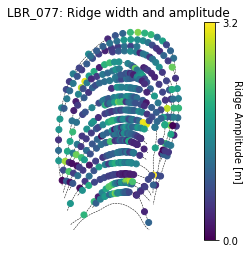

In [171]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

itx_plot = itx[itx["metric_confidence"]>1]
itx_plot = itx_plot[itx_plot["ridge_amp"] < 4]

itx_plot.plot(ax=ax, column="ridge_amp", legend=True, missing_kwds={"edgecolor":"k", "facecolor":"None"})
# itx.plot(ax=ax, markersize="ridge_width", facecolor=None)
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
# t.plot(ax=ax, color="k")


cbar = fig.axes[1]
min_max = itx_plot["ridge_amp"].quantile([0,1])
cbar.set_yticks(min_max, labels = np.round(min_max, 1))

cbar.set_ylabel("Ridge Amplitude [m]", rotation=270)

ax.set_title(f"{bend_id}: Ridge width and amplitude")
ax.set_axis_off()
# plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/{bend_id}_HighAmplitude.png", dpi=300)

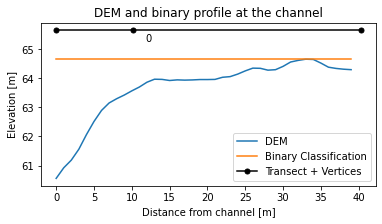

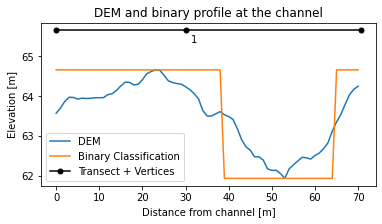

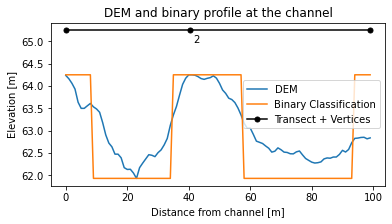

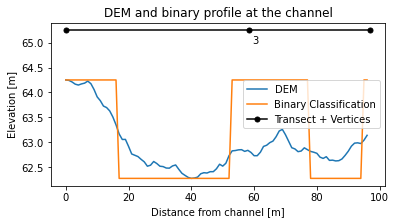

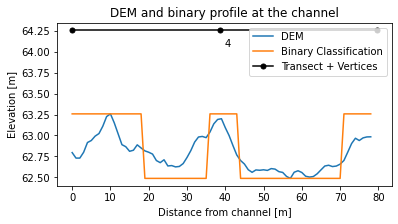

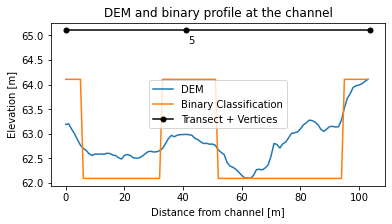

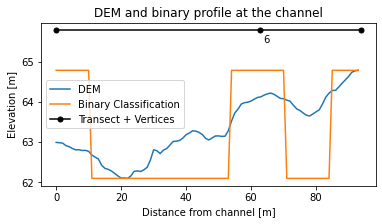

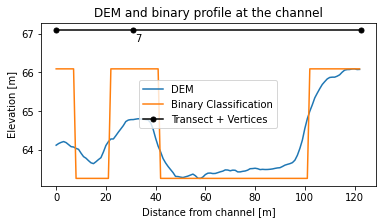

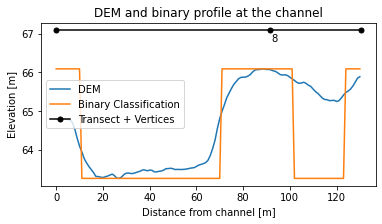

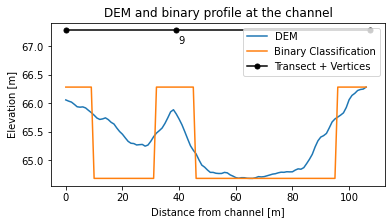

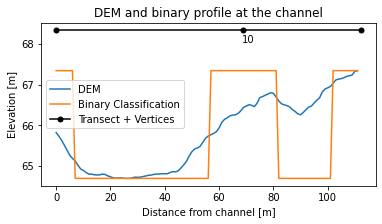

In [138]:
chosen_transect = itx.loc["t_031"].sort_values("transect_position")
for i, row in chosen_transect.iterrows():

    geom = row["substring_geometry"]
    dem_sig = row["dem_signal_selection"]
    # bin_sig = row["bin_signal"]
    bin_sig = row["bool_mask"]
    pos = row["transect_position"]
    dq_adj = row["swale_dq_adjustment"]

    fig, ax = plt.subplots(1,1, figsize=(6, 3))
    ax.plot(dem_sig, label="DEM")
    ax.plot((bin_sig * (np.nanmax(dem_sig)- np.nanmin(dem_sig)))+ np.nanmin(dem_sig), label="Binary Classification")

    p1, p2, p3 = [Point(p) for p in geom.coords]
    d1 = p1.distance(p2) - dq_adj
    d2 = p2.distance(p3)

    x = [0, d1, d1+d2]
    y = np.ones(3)*np.nanmax(dem_sig)+1
    ax.plot(x, 
            y,
            color="k",
            marker=".",
            markersize=10,
            label = "Transect + Vertices")
    
    ax.annotate(pos, (x[1]+2, y[1]-0.1), verticalalignment="top", horizontalalignment="center", )
    ax.legend()
    ax.set_title("DEM and binary profile at the channel")
    ax.set_ylabel("Elevation [m]")
    ax.set_xlabel("Distance from channel [m]")